In [363]:
import os
import ast
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [422]:
europe = gpd.read_file('europe.geojson')
europe.head()

,pop_est,continent,name,iso_a3,gdp_md_est,danceability,iso_a2,key,acousticness,loudness,...,mode_variance,speechiness_variance,instrumentalness_variance,liveness_variance,valence_variance,tempo_variance,duration_ms_variance,time_signature_variance,mpg,geometry
0,5320045,Europe,Norway,NOR,364700.0,NaN,NO,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"POLYGON ((31.10104 69.55810, 29.39955 69.15692..."
1,67106161,Europe,France,FRA,2699000.0,0.730461,FR,1.0,0.293746,-6.762002,...,1.218199,0.766087,8.480532,0.704901,0.412406,0.208992,0.219708,0.075655,french hip hop,"POLYGON ((6.18632 49.46380, 6.65823 49.20196, ..."
2,9960487,Europe,Sweden,SWE,498100.0,NaN,SE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"POLYGON ((11.02737 58.85615, 11.46827 59.43239..."
3,9549747,Europe,Belarus,BLR,165400.0,0.681072,BY,1.0,0.211475,-7.080634,...,1.068279,0.856175,3.332651,0.687478,0.476685,0.239028,0.259342,0.051725,russian hip hop,"POLYGON ((28.17671 56.16913, 29.22951 55.91834..."
4,44033874,Europe,Ukraine,UKR,352600.0,NaN,UA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"POLYGON ((31.78599 52.10168, 32.15944 52.06125..."


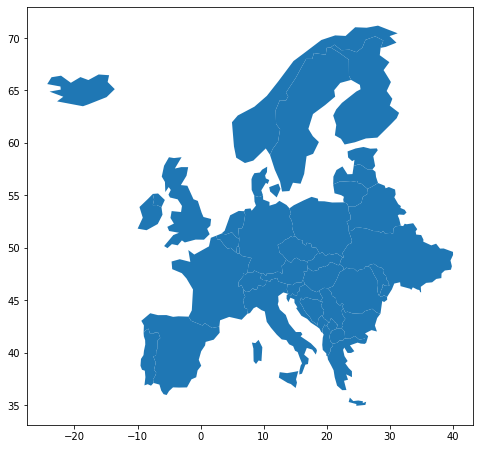

In [424]:
europe.plot(figsize=(8,8))
plt.show()

In [255]:
def get_ids(country: str) -> list[str]:
    """fetches all track ids from charts (possible improvement - caching ids in separate file)"""
    country = country.lower()
    data_root_dir = f'../data/scraped_data/{country}'
    all_files = [f'{dir_name}/{file}' for dir_name, _, files in os.walk(data_root_dir) for file in files]
    all_ids = set()
    for file_name in all_files:
        df = pd.read_csv(file_name, sep=';')
        all_ids.update(df['track_id'])
    return list(all_ids)

In [256]:
all_features = pd.read_csv('../data/features.csv')
def create_country_features(country: str) -> pd.DataFrame:
    track_ids = get_ids(country)
    return all_features[all_features.track_id.isin(track_ids)]

In [327]:
track_features_names = [
    'danceability',
    'key',
    'acousticness',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
]

In [306]:
categorical_features_names = ['key', 'key_2', 'time_signature', 'time_signature_2']

In [312]:
def fill_mean_country_features(gdf: gpd.GeoDataFrame, country: str):
    features = create_country_features(country)
    gdf.loc[europe.iso_a2 == country, 'danceability'] = features['danceability'].mean()
    gdf.loc[europe.iso_a2 == country, 'key'] = features['key'].mode()[0]
    key_1 = features['key'].mode()[0]
    key_2 = features[features.key != key_1]['key'].mode()[0]
    gdf.loc[europe.iso_a2 == country, 'key'] = key_1
    gdf.loc[europe.iso_a2 == country, 'key_2'] = key_2
    gdf.loc[europe.iso_a2 == country, 'acousticness'] = features['acousticness'].mean()
    gdf.loc[europe.iso_a2 == country, 'loudness'] = features['loudness'].mean()
    gdf.loc[europe.iso_a2 == country, 'mode'] = features['mode'].mean()
    gdf.loc[europe.iso_a2 == country, 'speechiness'] = features['speechiness'].mean()
    gdf.loc[europe.iso_a2 == country, 'acousticness'] = features['acousticness'].mean()
    gdf.loc[europe.iso_a2 == country, 'instrumentalness'] = features['instrumentalness'].mean()
    gdf.loc[europe.iso_a2 == country, 'liveness'] = features['liveness'].mean()
    gdf.loc[europe.iso_a2 == country, 'valence'] = features['valence'].mean()
    gdf.loc[europe.iso_a2 == country, 'tempo'] = features['tempo'].mean()
    gdf.loc[europe.iso_a2 == country, 'duration_ms'] = features['duration_ms'].mean()
    time_signature_1 = features['time_signature'].mode()[0]
    time_signature_2 = features[features.time_signature != time_signature_1]['time_signature'].mode()[0]
    gdf.loc[europe.iso_a2 == country, 'time_signature'] = time_signature_1
    gdf.loc[europe.iso_a2 == country, 'time_signature_2'] = time_signature_2

In [343]:
def fill_variance_country_features(gdf: gpd.GeoDataFrame, country: str):
    features = create_country_features(country)
    for f_name in track_features_names:
        norm_std_dev = features[f_name].std() / features[f_name].mean()
        gdf.loc[europe.iso_a2 == country, f'{f_name}_variance'] = norm_std_dev

In [406]:
artists = pd.read_csv('../data/artists.csv')
tracks = pd.read_csv('../data/tracks.csv')
def fill_most_popular_genre(gdf: gpd.GeoDataFrame, country: str):
    features = create_country_features(country)
    genres = []
    for t_id in features['track_id']:
        try:
            artists_ids = ast.literal_eval(tracks.loc[tracks.id == t_id, 'artists_ids'].iloc[0])
        except IndexError:
            artists_ids = []
        for art_id in artists_ids:
            try:
                genres.extend(ast.literal_eval(artists.loc[artists.id == art_id, 'genres'].iloc[0]))
            except IndexError:
                pass
    gdf.loc[europe.iso_a2 == country, 'mpg'] = pd.Series(genres).mode()[0]

In [301]:
for country in os.listdir('../data/scraped_data/'):
    fill_mean_country_features(europe, country.upper())

In [344]:
for country in os.listdir('../data/scraped_data/'):
    fill_variance_country_features(europe, country.upper())

In [410]:
for country in os.listdir('../data/scraped_data/'):
    fill_most_popular_genre(europe, country.upper())

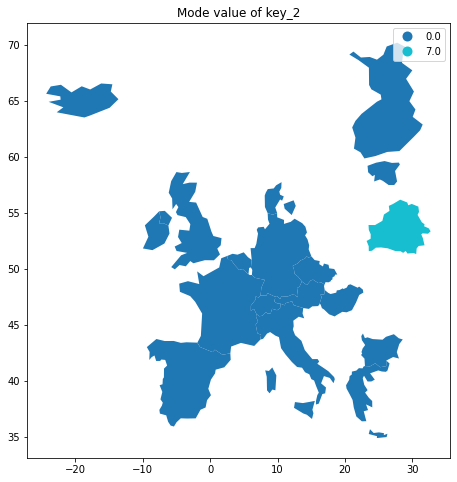

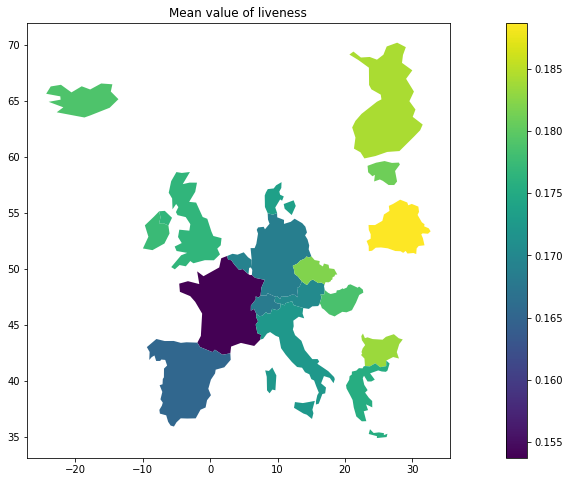

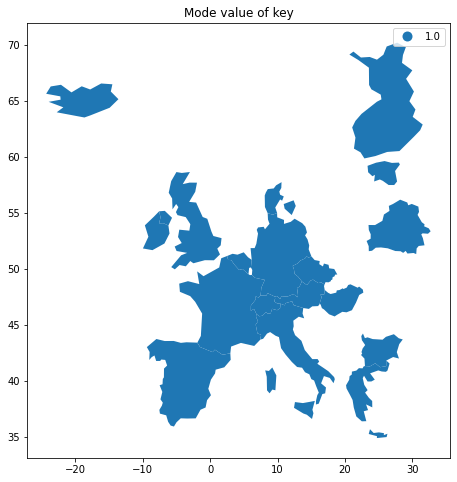

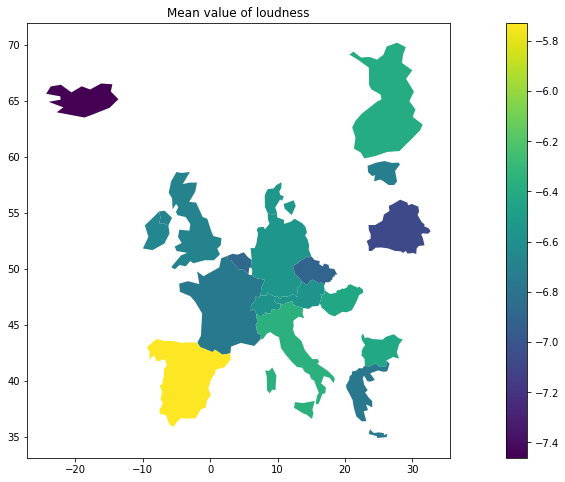

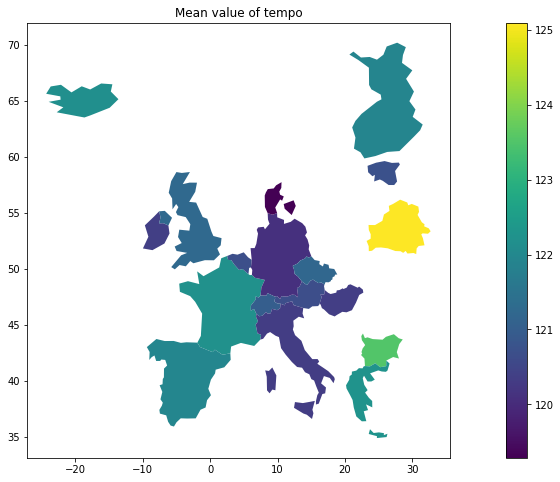

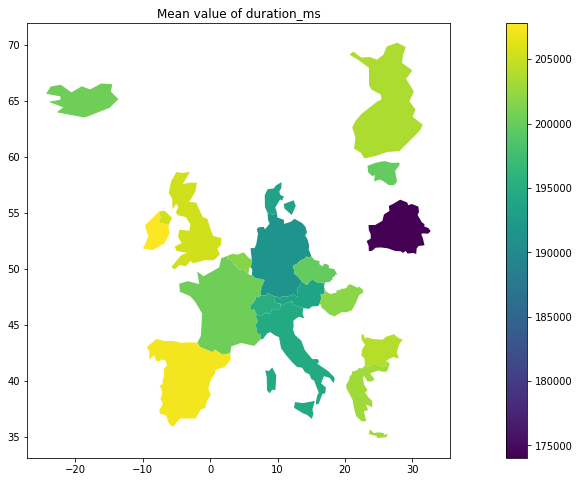

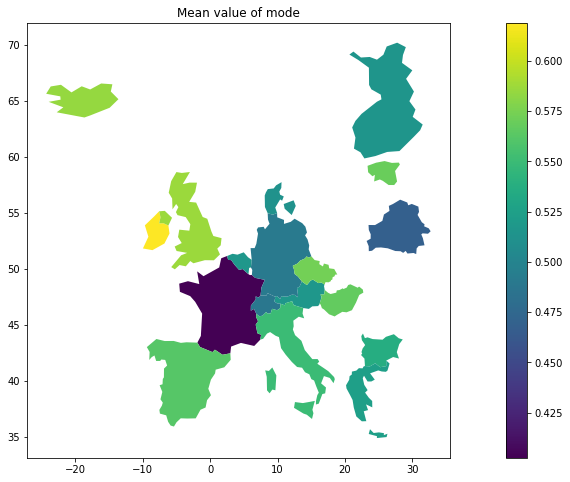

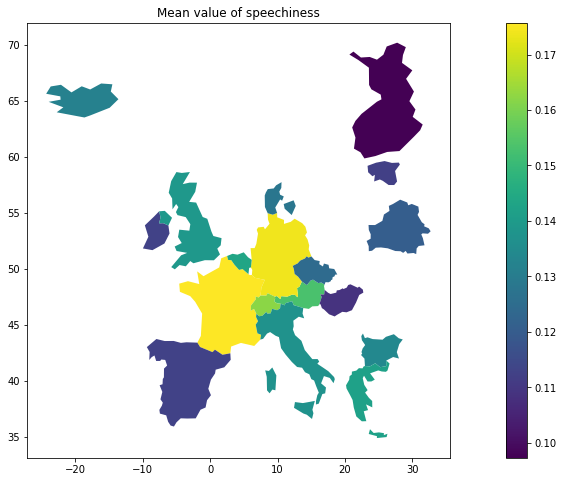

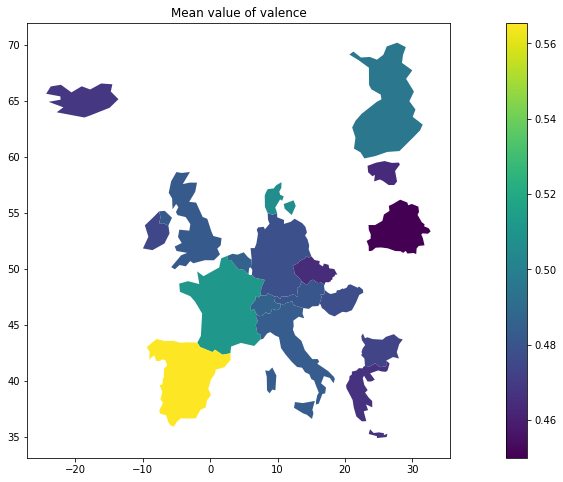

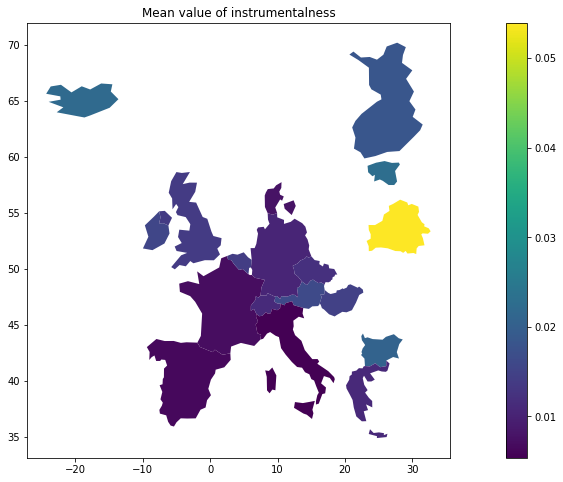

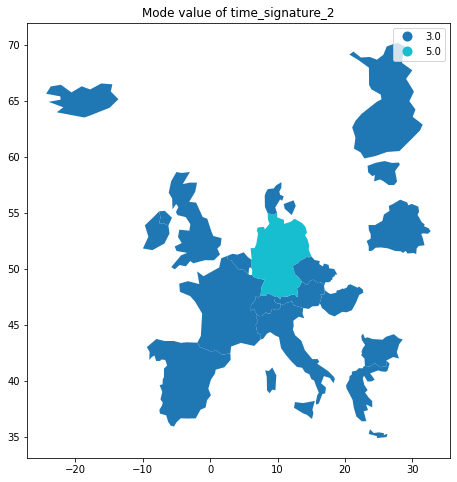

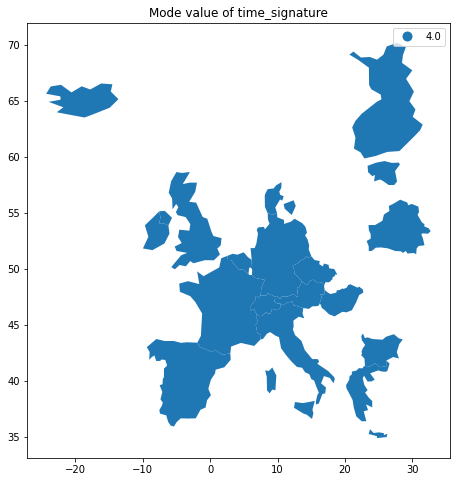

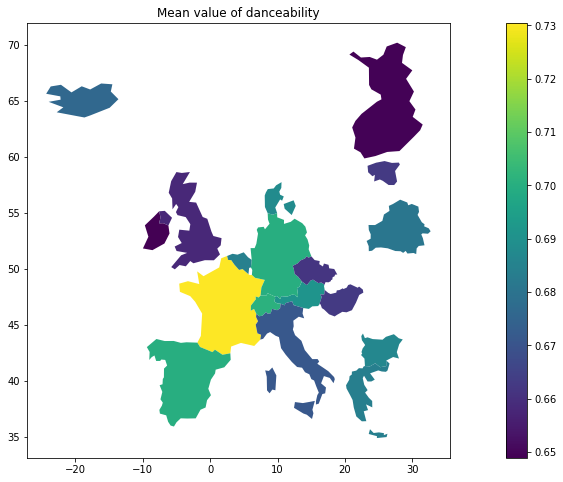

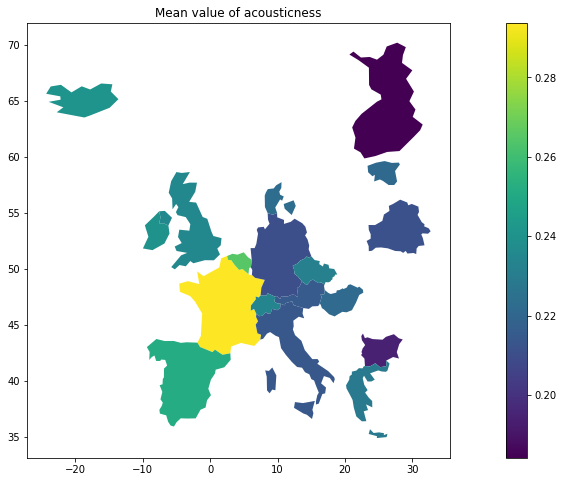

In [413]:
for feature_name in set(track_features_names + categorical_features_names):
    categorical = feature_name in categorical_features_names
    prefix = 'Mode' if categorical else 'Mean'
    europe.plot(figsize=(20,8), column=feature_name, legend=True, categorical=categorical)
    plt.title(f'{prefix} value of {feature_name}')
    plt.show()

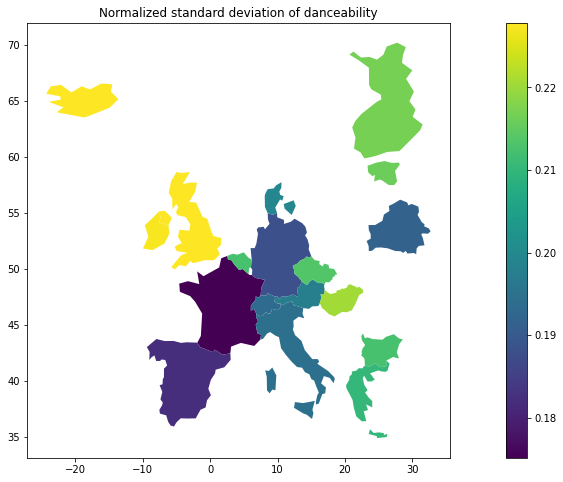

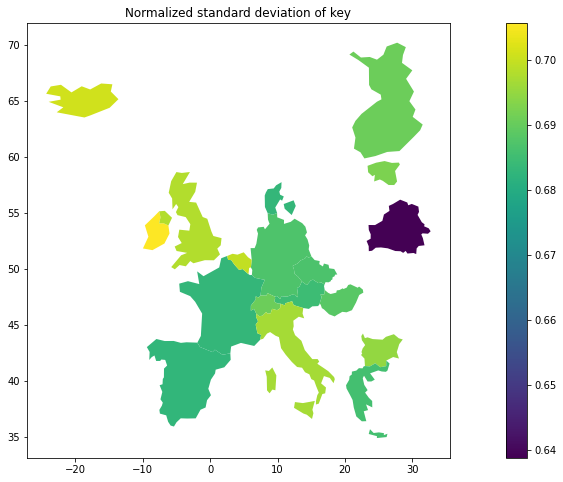

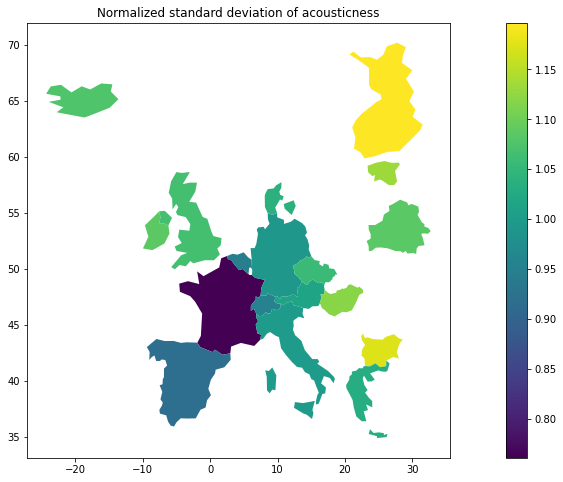

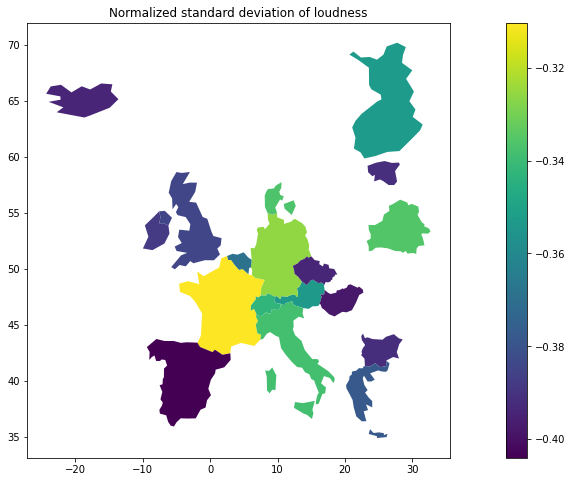

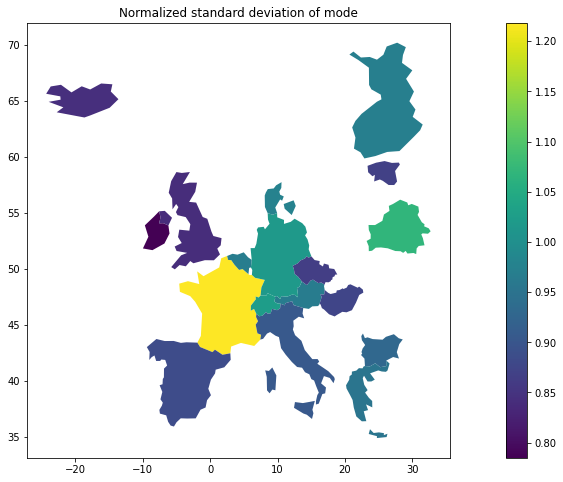

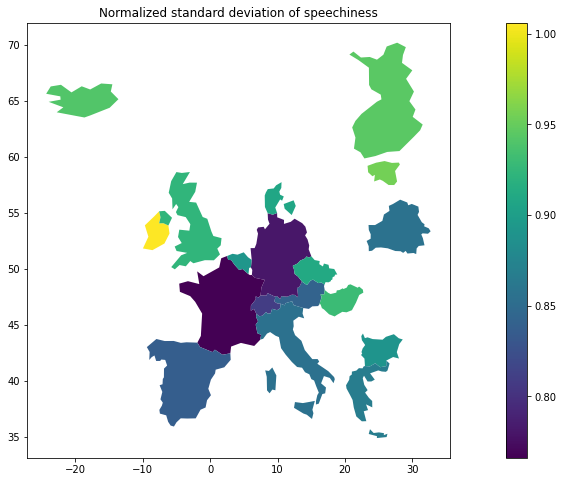

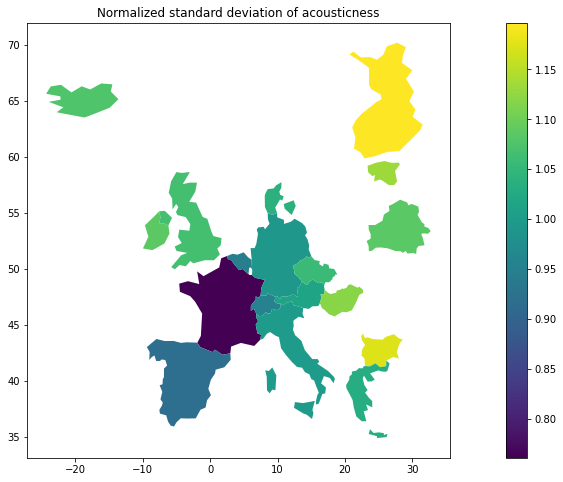

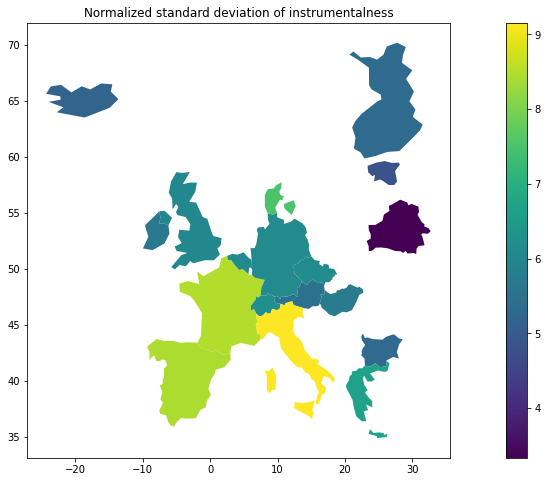

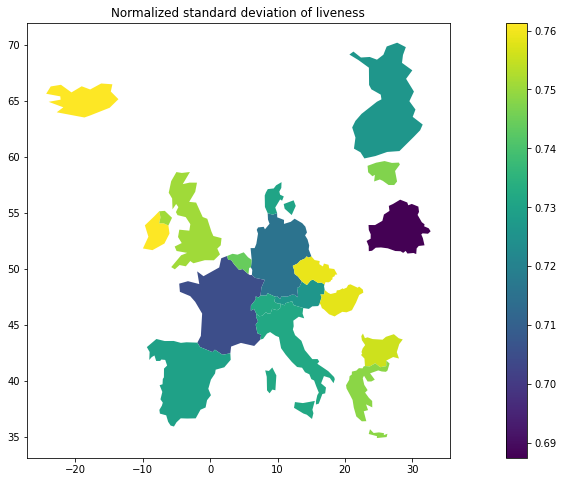

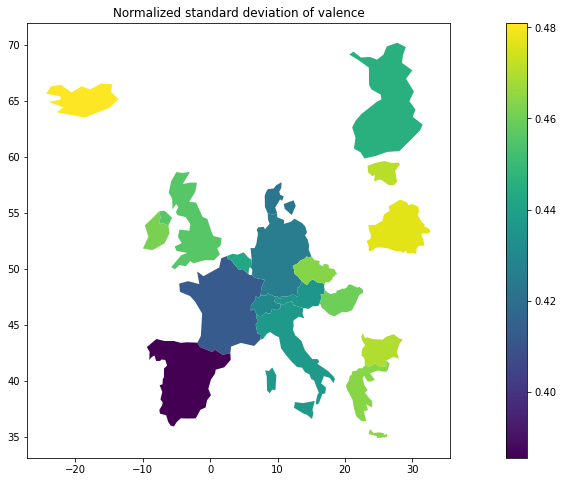

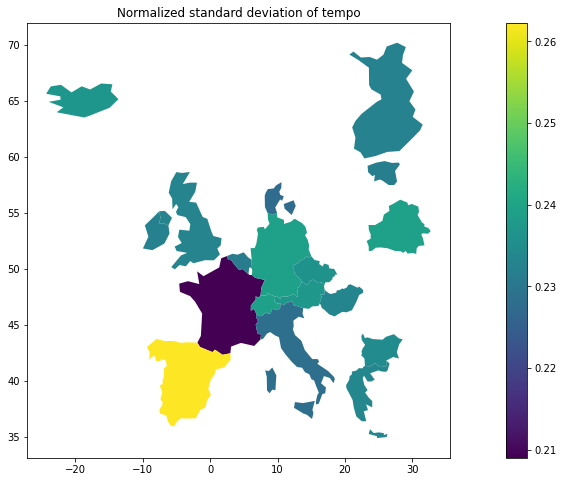

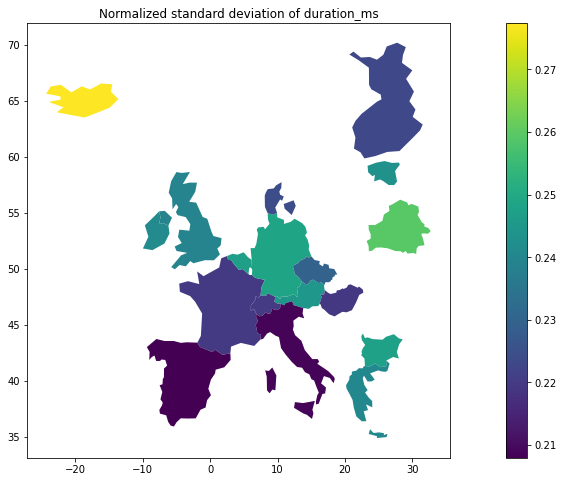

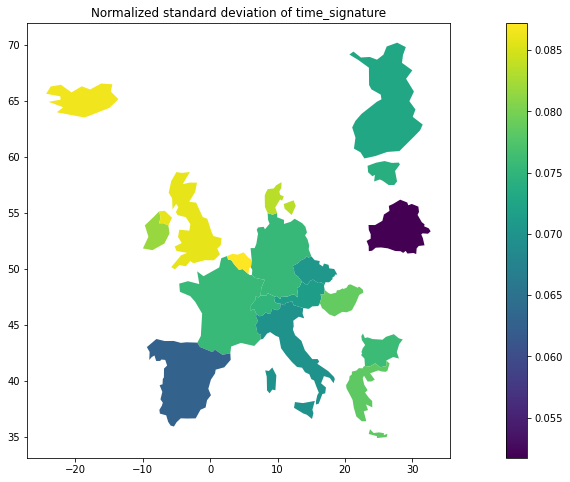

In [345]:
for feature_name in track_features_names:
    europe.plot(figsize=(20,8), column=f'{feature_name}_variance', legend=True)
    plt.title(f'Normalized standard deviation of {feature_name}')
    plt.show()

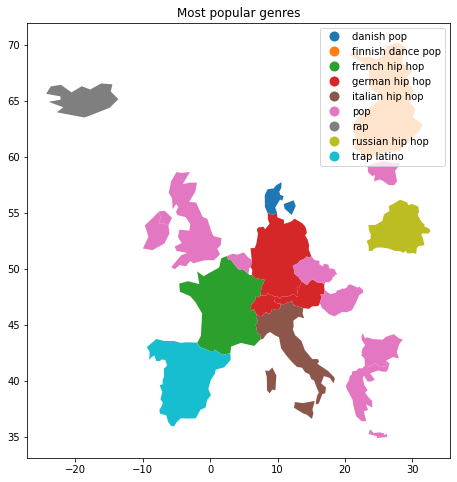

In [412]:
europe.plot(figsize=(20,8), column='mpg', legend=True)
plt.title(f'Most popular genres')
plt.show()

In [417]:
europe.to_file('europe.geojson', driver='GeoJSON')  

/home/pawel/.local/share/virtualenvs/eksploracja-danych-mWY76ITK/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
